# Section 3 - Identifying features that may drive outcomes

## Example 3.2
**Application 3.2**: What features might drive differential translation rates as measured by ribosome profiling when specific amino acids are in the A- and P-sites of the ribosome?

* Translation is a key biological process during which ribosomes synthesize proteins based on messenger RNA (mRNA) templates
* During translation elongation, amino acids are added one at a time to the nascent protein (**Figure 3.2.1**)
* The speed at which amino acids are added can be an important factor in determining if a protein will fold and function or misfold and malfunction

![](../images/Ribosome_mRNA_translation_en.svg.png)
**Figure 3.2.1** *The ribosome has three sites that accommodate tRNA: the A-, P- and E-sites. The ribosome ratchets along the mRNA, presenting different mRNA codons for decoding by aminoacyl-tRNA (aa-tRNA) at the A-site and catalyzing peptide bond formation between the nascent protein bound to the P-site tRNA and the amino acid bound to the A-site aa-tRNA. The E-site binds the deacylated tRNA before it exits the ribosome. Reproduced from https://en.wikipedia.org/wiki/Translation_(biology)*
  
* Many different factors are thought to influence the speed of translation
* In this application, we will explore using LASSO to determine which physicochemical properties are most useful in predicting how different combinations of amino acids and tRNA in the A- and P-sites of the ribosome influence translation speed


### Step 0 - Load libraries

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

### Step 1 - Load the data & explore
* In this instance, the features and outcome are in two separate files

In [2]:
# data7_features & data7_outcomes are both DataFrame objects
data_path      = "/home/jovyan/data-store/data/iplant/home/shared/NCEMS/BPS-training-2025/"
data7_features = pd.read_csv(data_path+"ta_transformed_features.csv")
data7_outcomes = pd.read_csv(data_path+"ta_transformed-data_targets.csv")

# both of these DataFrames have an unneeded first column, so we will remove it
data7_features = data7_features.iloc[:, 1:]
data7_outcomes = data7_outcomes.iloc[:, 1:]

print ("Summary of the features:\n")
display(data7_features.head(10))
display(data7_features.info())

print ("\nSummary of the outcomes:\n")
display(data7_outcomes.head(10))
display(data7_outcomes.info())

Summary of the features:



,molecular-weight,residue-weight,pKa,pKb,pKx,pI,hp-kd,bb=sc,charge,volume,...,T-stem2,Acc-stem2,CCA,Category-Not-Found,Total,AntiCodon3,asitetrna,psitetrna,asiteaa,psiteaa
0,-1.738756,-1.778904,0.809351,0.511075,0.003250,-0.104711,1.056406,-0.312761,0.063085,-1.443226,...,-0.200366,-0.223654,-0.237966,1.042375,-0.623204,0.395781,A-t1,A-t1,A,A
1,-0.479951,-0.494600,-1.126355,1.803312,0.003250,-0.579427,1.474742,-0.312761,0.063085,-0.850264,...,-0.200366,-0.223654,-0.237966,-0.766054,-0.190813,-0.765462,A-t1,C-t1,A,C
2,-0.005942,-0.010616,-1.531696,0.314324,-2.191927,-1.737091,-1.429836,-0.312761,-3.107030,-0.772395,...,-0.200366,-0.223654,-0.237966,-0.766054,-1.293589,-0.765462,A-t1,D-t1,A,D
3,0.553548,0.562190,0.043208,0.467344,-1.904829,-1.512403,-1.429836,-0.312761,-3.107030,0.050820,...,-0.200366,-0.223654,-0.237966,-0.766054,-2.445107,-0.765462,A-t1,E-t2,A,E
4,1.279681,1.306135,-1.784651,-0.711573,0.003250,-0.370619,1.662330,-0.312761,0.063085,1.632108,...,-0.200366,-0.223654,-0.237966,0.130562,0.890090,0.395781,A-t1,F-t1,A,F
5,0.875650,0.891634,-1.835207,-0.624366,-1.061133,0.715915,-1.314600,-0.312761,1.064173,0.501420,...,-0.200366,-0.223654,-0.237966,-0.766054,-0.190813,-0.765462,A-t1,H-t1,A,H
6,0.515922,0.523672,-0.007773,-1.103767,1.167600,1.844031,-1.579684,-0.312761,1.064173,0.973549,...,-0.200366,-0.223654,-0.237966,1.042375,0.131705,-0.765462,A-t1,K-t1,A,K
7,-0.082676,-0.089064,0.911706,0.314324,0.003250,-0.114960,2.327081,-0.312761,0.063085,0.915118,...,-0.200366,-0.223654,-0.237966,0.130562,1.108903,-0.765462,A-t1,L-t4,A,L
8,0.636866,0.647490,0.502572,-0.537140,0.003250,-0.237816,1.114574,-0.312761,0.063085,0.798410,...,-0.200366,-0.223654,-0.237966,0.130562,0.510462,-0.765462,A-t1,M-t1,A,M
9,-0.718141,-0.737814,-0.974158,2.505948,0.003250,0.049249,-0.655096,3.275925,0.063085,-0.724430,...,-0.200366,-0.223654,-0.237966,0.130562,0.576202,0.395781,A-t1,P-t1,A,P


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Columns: 633 entries, molecular-weight to psiteaa
dtypes: float64(629), object(4)
memory usage: 3.9+ MB


None


Summary of the outcomes:



,Asite,Psite,percent-diff,
0,A-t1,A-t1,-8.176901,0
1,A-t1,C-t1,-17.741818,0
2,A-t1,D-t1,16.011557,1
3,A-t1,E-t2,-15.448015,0
4,A-t1,F-t1,-10.063853,0
5,A-t1,H-t1,29.766722,1
6,A-t1,K-t1,5.213059,1
7,A-t1,L-t4,8.685709,1
8,A-t1,M-t1,-16.649137,0
9,A-t1,P-t1,15.481030,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Asite         808 non-null    object 
 1   Psite         808 non-null    object 
 2   percent-diff  808 non-null    float64
 3            808 non-null    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 25.4+ KB


None

* What we are trying to predict is `Speed`, which is `0` if translation is faster for the given pair of amino acids in the A- and P-sites than average and `1` if it is slower than average
* These values were derived from ribosome profiling, a next-generation sequencing technique that specifically sequences fragments of mRNAs that are covered by the ribosome
* We will attempt to model `Speed` using the set of 629 features in `data7_features`
* Let's make sure that the features have each been scaled correctly

In [3]:
print ("\nInformation about mean and standard deviation of parameters:")
data7_features.describe()


Information about mean and standard deviation of parameters:


,molecular-weight,residue-weight,pKa,pKb,pKx,pI,hp-kd,bb=sc,charge,volume,...,Ac-stem2,V-region,T-stem1,T-loop,T-stem2,Acc-stem2,CCA,Category-Not-Found,Total,AntiCodon3
count,808.000000,8.080000e+02,8.080000e+02,8.080000e+02,8.080000e+02,8.080000e+02,8.080000e+02,8.080000e+02,8.080000e+02,8.080000e+02,...,8.080000e+02,8.080000e+02,8.080000e+02,8.080000e+02,8.080000e+02,8.080000e+02,8.080000e+02,8.080000e+02,8.080000e+02,8.080000e+02
mean,0.000000,-1.758769e-17,-6.595384e-18,1.538923e-17,-6.155692e-17,5.056461e-17,8.793846e-18,3.077846e-17,8.793846e-18,1.703808e-17,...,9.893076e-18,4.726692e-17,1.099231e-17,1.868692e-17,1.099231e-16,1.758769e-17,2.462277e-16,-3.077846e-17,8.793846e-18,5.496154e-18
std,1.000619,1.000619e+00,1.000619e+00,1.000619e+00,1.000619e+00,1.000619e+00,1.000619e+00,1.000619e+00,1.000619e+00,1.000619e+00,...,1.000619e+00,1.000619e+00,1.000619e+00,1.000619e+00,1.000619e+00,1.000619e+00,1.000619e+00,1.000619e+00,1.000619e+00,1.000619e+00
min,-2.442131,-2.527703e+00,-2.064775e+00,-1.477948e+00,-3.003972e+00,-2.329694e+00,-2.728074e+00,-3.127613e-01,-3.107030e+00,-2.618727e+00,...,-8.503111e-01,-1.985877e+00,-8.393183e-01,-1.370088e+00,-2.003655e-01,-2.236536e-01,-2.379662e-01,-2.515191e+00,-3.154981e+00,-1.892550e+00
25%,-0.591934,-5.989729e-01,-4.833735e-01,-7.318487e-01,-2.127222e-03,-2.904044e-01,-6.344190e-01,-3.127613e-01,6.308469e-02,-6.601098e-01,...,-8.503111e-01,-5.922514e-01,-8.393183e-01,-1.114230e+00,-2.003655e-01,-2.236536e-01,-2.379662e-01,1.305618e-01,-4.721559e-01,-7.654615e-01
50%,-0.036196,-3.525555e-02,4.335576e-02,-1.464536e-01,3.250223e-03,-1.261844e-01,-9.895475e-02,-3.127613e-01,6.308469e-02,9.945293e-02,...,-2.269404e-01,-1.071175e-01,-3.220408e-01,7.649454e-01,-2.003655e-01,-2.236536e-01,-2.379662e-01,1.417253e-01,1.791005e-01,3.957811e-01
75%,0.528912,5.296224e-01,7.321650e-01,3.600857e-01,3.250223e-03,1.075296e-02,4.129708e-01,-3.127613e-01,3.800961e-01,7.649899e-01,...,4.185946e-01,5.382254e-01,1.605993e+00,7.649454e-01,-2.003655e-01,-2.236536e-01,-2.379662e-01,1.417253e-01,6.095507e-01,3.957811e-01
max,3.054014,3.167796e+00,3.771015e+00,2.632413e+00,3.012865e+00,3.323830e+00,3.546362e+00,3.275925e+00,1.064173e+00,3.208572e+00,...,3.830079e+00,2.849427e+00,1.605993e+00,9.140131e-01,5.769773e+00,4.628624e+00,4.675962e+00,3.008398e+00,2.722634e+00,4.148644e+00


* We can see that the features have already been scaled - they have a mean of zero and standard deviation of one
* Finally, we need to check the balance of the outcome classes

In [4]:
# calculate counts per outcome class
class_counts = data7_outcomes["Speed"].value_counts()
print (class_counts)

Speed
0    439
1    369
Name: count, dtype: int64


* We can see that the `0` class accounts for 54% of that data and the `1` class accounts for 46% of the data
* This is reasonably well balanced, but we should remain aware of the class imbalance all the same

### Step 2 - Prepare data for model building

* As in **Example 3.1**, we will use k-fold cross-validation with a grid search over *λ*

In [5]:
# set random seed to achieve reproducible results
random_seed = 1

# number of folds for cross-validation
Nfolds      = 5

# define feature and outcome data sets; note that we need to drop some non-numerical columns from the feature space
X           = data7_features.drop(["asitetrna", "psitetrna", "asiteaa", "psiteaa"], axis=1)
y           = data7_outcomes["Speed"]

# reserve 20% of data for final testing after hyperparameter tuning
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)

# set up k-fold cross-validation with outcome stratification
kf          = StratifiedKFold(n_splits=Nfolds, shuffle=True, random_state=random_seed)

# define a range of lambda values to be used in our grid search
lambda_vals = np.logspace(-1, 4, 6)

### Step 3 - Optimize λ
* We are now ready to run cross-validation for each value of *λ* and decide which value we want to use for our final model

In [6]:
# record the start time
startTime    = datetime.now()

# maximum number of iterations to be run
max_iter     = 20000

# setup dictionary to store results for each value of lambda
results_dict = {}

# loop over lambda values
for lambda_val in lambda_vals:

    # setup logistic regression model
    model                    = LogisticRegression(penalty="l1", solver="saga", 
                                                  max_iter=max_iter, C=1/lambda_val)

    # run cross-validation for current lambda_val
    cv_results               = cross_validate(model, X_train, y_train, cv=kf, return_estimator=True, 
                                              scoring=['balanced_accuracy', 'roc_auc'], n_jobs=-1)

    # store results for later
    results_dict[lambda_val] = cv_results

    # calculation elapsed time and print it to the screen
    elapsed_sec              = (datetime.now() - startTime).total_seconds()
    print(f"{lambda_val:10.4f} {elapsed_sec:10.2f} s")

    0.1000      28.74 s
    1.0000      47.59 s
   10.0000      61.83 s
  100.0000      63.31 s
 1000.0000      63.52 s
10000.0000      63.72 s


* Let's assess performance and number of features as a function of *λ*

Lambda      Balanced Acc (mean ± std)  AUROC (mean ± std)            Non-zero Coeffs (mean ± std)
    0.1000	0.889 ± 0.030		0.957 ± 0.013		     278.6 ±        5.5
    1.0000	0.895 ± 0.031		0.963 ± 0.011		     119.4 ±        6.8
   10.0000	0.878 ± 0.029		0.956 ± 0.011		      36.8 ±        1.6
  100.0000	0.799 ± 0.014		0.884 ± 0.024		       2.4 ±        0.5
 1000.0000	0.500 ± 0.000		0.500 ± 0.000		       0.0 ±        0.0
10000.0000	0.500 ± 0.000		0.500 ± 0.000		       0.0 ±        0.0


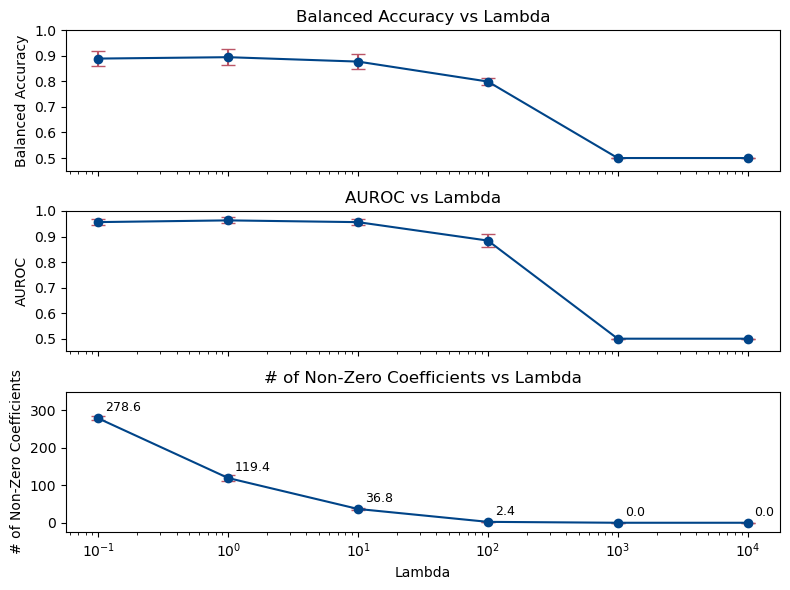

In [7]:
# sort the lambda values
lambda_vals = sorted(results_dict.keys())

# initialize lists to store the aggregated metric means and standard deviations
bal_acc_means, bal_acc_stds = [],[]
auroc_means, auroc_stds     = [],[]
nonzero_means, nonzero_stds = [],[]

# loop over each lambda and compute metrics
for lambda_val in lambda_vals:
    
    cv_results     = results_dict[lambda_val]
    
    # extract balanced accuracy and AUROC scores
    test_bal_acc   = cv_results['test_balanced_accuracy']
    test_roc_auc   = cv_results['test_roc_auc']
    
    # compute mean and standard deviation
    mean_bal_acc   = np.mean(test_bal_acc)
    std_bal_acc    = np.std(test_bal_acc, ddof=1)
    mean_roc_auc   = np.mean(test_roc_auc)
    std_roc_auc    = np.std(test_roc_auc, ddof=1)
    
    # compute number of non-zero coefficients for each fold
    nonzero_counts = [np.count_nonzero(estimator.coef_[0]) for estimator in cv_results['estimator']]
    mean_nonzero   = np.mean(nonzero_counts)
    std_nonzero    = np.std(nonzero_counts, ddof=1)
    
    # Append the computed metrics to the corresponding lists
    bal_acc_means.append(mean_bal_acc)
    bal_acc_stds.append(std_bal_acc)
    auroc_means.append(mean_roc_auc)
    auroc_stds.append(std_roc_auc)
    nonzero_means.append(mean_nonzero)
    nonzero_stds.append(std_nonzero)

# print summary information to screen
header = ("Lambda".ljust(12) + "Balanced Acc (mean ± std)".ljust(27) +
          "AUROC (mean ± std)".ljust(30) + "Non-zero Coeffs (mean ± std)")
print(header)

for i, lambda_val in enumerate(lambda_vals):
    nonzero_str = f"{nonzero_means[i]:10.1f} ± {nonzero_stds[i]:10.1f}"
    print(f"{lambda_val:10.4f}\t" f"{bal_acc_means[i]:0.3f} ± {bal_acc_stds[i]:0.3f}\t\t"
          f"{auroc_means[i]:0.3f} ± {auroc_stds[i]:0.3f}\t\t" f"{nonzero_str}")

# create summary plots
plot_color  = "#004488"
error_color = "#BB5566"
fig, axes   = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

# plot Balanced Accuracy
axes[0].errorbar(lambda_vals, bal_acc_means, yerr=bal_acc_stds, fmt='o-', capsize=5, color=plot_color, ecolor=error_color)
axes[0].set_xscale('log')
axes[0].set_ylabel('Balanced Accuracy')
axes[0].set_ylim(0.45, 1.0)
axes[0].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
axes[0].set_title('Balanced Accuracy vs Lambda')

# plot AUROC
axes[1].errorbar(lambda_vals, auroc_means, yerr=auroc_stds, fmt='o-', capsize=5, color=plot_color, ecolor=error_color)
axes[1].set_xscale('log')
axes[1].set_ylabel('AUROC')
axes[1].set_ylim(0.45, 1.0)
axes[1].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
axes[1].set_title('AUROC vs Lambda')

# plot number of non-zero coefficients
axes[2].errorbar(lambda_vals, nonzero_means, yerr=nonzero_stds, fmt='o-', capsize=5,color=plot_color, ecolor=error_color)
axes[2].set_xscale('log')
axes[2].set_ylabel('# of Non-Zero Coefficients')
axes[2].set_title('# of Non-Zero Coefficients vs Lambda')
axes[2].set_ylim(-25, 350)
axes[2].set_xlabel('Lambda')

# annotate each point with the mean number of non-zero coefficients (to one decimal)
for i, lambda_val in enumerate(lambda_vals):
    axes[2].annotate(f"{nonzero_means[i]:.1f}", (lambda_val, nonzero_means[i]), 
                     textcoords="offset points", xytext=(5, 5), fontsize=9, color='black')

plt.tight_layout()
plt.show()

* This plot and the associated data indicate that *λ* = 1 provides the best model performance based on balanced accuracy & AUROC
* As in **Exercise 3.1**, we will use a larger value of *λ* = 10 to limit the size of the non-zero feature space, improving interpretability

### Step 4 - Build & test the final model

In [8]:
# choose our preferred value of lambda
final_lambda        = 10.

# setup the model
final_model         = LogisticRegression(penalty="l1", solver="saga", max_iter=max_iter, C=1/final_lambda)

# fit the model to the data
final_model.fit(X_train, y_train)

# evaluate the final model on the holdout dataset
y_holdout_pred_prob = final_model.predict_proba(X_holdout)[:, 1]
y_holdout_pred      = final_model.predict(X_holdout)
holdout_auroc       = roc_auc_score(y_holdout, y_holdout_pred_prob)
holdout_bal_acc     = balanced_accuracy_score(y_holdout, y_holdout_pred)

print ("Performance on holdout data\n")
print("Holdout AUROC             :", '%.3f' %holdout_auroc)
print("Holdout Balanced Accuracy :", '%.3f' %holdout_bal_acc, "\n")

# extract the nonzero coefficients
coef                = final_model.coef_.flatten()
nonzero_indices     = coef != 0
nonzero_coefs       = coef[nonzero_indices]
nonzero_features    = X_train.columns[nonzero_indices]

# sort coefficients by absolute magnitude in descending order
sorted_indices      = abs(nonzero_coefs).argsort()[::-1]
sorted_features     = nonzero_features[sorted_indices]
sorted_coefs        = nonzero_coefs[sorted_indices]

# print nonzero coefficients
print(len(sorted_coefs), "Nonzero Coefficients (sorted by magnitude)\n")
for feature, value in zip(sorted_features, sorted_coefs):
    print(feature.ljust(26) + ": " + "%.5f" % value)

Performance on holdout data

Holdout AUROC             : 0.935
Holdout Balanced Accuracy : 0.849 

41 Nonzero Coefficients (sorted by magnitude)

V-region                  : -0.82448
2NT-Codon-Anticodon       : 0.80059
CHOP780207                : 0.55514
3                         : -0.37403
RICJ880116                : 0.37261
MAXF760103                : 0.36795
VASM830101                : 0.35591
+                         : -0.34916
I                         : -0.25216
X                         : 0.24667
.                         : 0.24667
AURR980111                : -0.24317
Ac-loop                   : 0.22366
solubility                : 0.21016
SUEM840101                : -0.19239
"                         : 0.16712
&                         : 0.14531
GEIM800104                : -0.13244
QIAN880122                : 0.13211
MAXF760101                : -0.12514
MEEJ810101                : -0.12171
RADA880102                : -0.11207
ROBB760113                : 0.11034
QIAN880124      

### Step 5 - Assess the results
* When you are done, consider the following questions:
    * If you were tasked with using the results of this analysis to formulate a hypothesis about the features that are critical for determining translation speed, where would you start?
    * If we were satisfied with lower accuracy but wanted a smaller number of features to interpret, how could we achieve this?
* Use the QR code below to test your knowledge

![](../images/section-3-example-2.png)

[Quiz Link](https://forms.gle/KVoQcVgk9rqHitpV7)